## Importing all the essential libraries

In [1]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [2]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
ttc_df = pd.read_csv("./data/TTC.csv")

## Overview

In [4]:
ttc_df.describe()

Route      Min Delay       Min Gap        Vehicle
count  656439.000000  657427.000000  656911.00000  586524.000000
mean      139.803837      20.059842      30.37430    5557.049693
std      1137.584571     310.882246      67.85782    3541.906856
min         1.000000     -54.000000      -2.00000       0.000000
25%        38.000000       7.000000      14.00000    1612.000000
50%        72.000000      10.000000      20.00000    7653.000000
75%       116.000000      16.000000      30.00000    8374.000000
max    898630.000000  246245.000000    6528.00000   99035.000000

In [5]:
ttc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 657922 entries, 0 to 657921
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Report Date  657922 non-null  object 
 1   Route        656439 non-null  float64
 2   Time         657922 non-null  object 
 3   Day          657922 non-null  object 
 4   Location     657113 non-null  object 
 5   Incident     656987 non-null  object 
 6   Min Delay    657427 non-null  float64
 7   Min Gap      656911 non-null  float64
 8   Direction    613331 non-null  object 
 9   Vehicle      586524 non-null  float64
dtypes: float64(4), object(6)
memory usage: 50.2+ MB


In [6]:
ttc_df.columns.to_list()

['Report Date',
 'Route',
 'Time',
 'Day',
 'Location',
 'Incident',
 'Min Delay',
 'Min Gap',
 'Direction',
 'Vehicle']

In [7]:
ttc_df.isna().sum()

Report Date        0
Route           1483
Time               0
Day                0
Location         809
Incident         935
Min Delay        495
Min Gap         1011
Direction      44591
Vehicle        71398
dtype: int64

In [8]:
ttc_df.head()

Report Date  Route         Time        Day              Location  \
0    1/1/2014   95.0  12:23:00 AM  Wednesday    York Mills station   
1    1/1/2014  102.0  12:55:00 AM  Wednesday  Entire run for route   
2    1/1/2014   54.0   1:28:00 AM  Wednesday   lawrence and Warden   
3    1/1/2014  112.0   1:30:00 AM  Wednesday       Kipling Station   
4    1/1/2014   24.0   1:37:00 AM  Wednesday      VP and Ellesmere   

             Incident  Min Delay  Min Gap Direction  Vehicle  
0          Mechanical       10.0     20.0         E   1734.0  
1       General Delay       33.0     66.0       b/w   8110.0  
2          Mechanical       10.0     20.0        WB   7478.0  
3  Emergency Services       18.0     36.0         N   8084.0  
4       Investigation       10.0     20.0         n   7843.0

## Data Cleaning

In [9]:
#Trimming data frame
def trim(dataset):
    # Using .strip() to remove the leading and the trailing white spaces in each cell
    trim = lambda x: x.strip() if type(x) is str else x
    return dataset.applymap(trim)

ttc_df = trim(ttc_df)

# Renaming column names
ttc_df = ttc_df.rename(columns={'Report Date': 'Report_Date', 'Day': 'Day_of_week', 'Min Delay': 'Min_Delay', 'Min Gap': 'Min_Gap'})


In [10]:
ttc_df.columns

Index(['Report_Date', 'Route', 'Time', 'Day_of_week', 'Location', 'Incident',
       'Min_Delay', 'Min_Gap', 'Direction', 'Vehicle'],
      dtype='object')

In [11]:
# Converting the 'Report_Date' column to date 
ttc_df['Report_Date'] = pd.to_datetime(ttc_df['Report_Date'], errors='coerce')

In [12]:
# Create new columns for date, month, and year
ttc_df['Report_Day'] = ttc_df['Report_Date'].dt.day
ttc_df['Report_Month'] = ttc_df['Report_Date'].dt.strftime('%b')
ttc_df['Report_Year'] = ttc_df['Report_Date'].dt.year

In [13]:
ttc_df.head()

Report_Date  Route         Time Day_of_week              Location  \
0  2014-01-01   95.0  12:23:00 AM   Wednesday    York Mills station   
1  2014-01-01  102.0  12:55:00 AM   Wednesday  Entire run for route   
2  2014-01-01   54.0   1:28:00 AM   Wednesday   lawrence and Warden   
3  2014-01-01  112.0   1:30:00 AM   Wednesday       Kipling Station   
4  2014-01-01   24.0   1:37:00 AM   Wednesday      VP and Ellesmere   

             Incident  Min_Delay  Min_Gap Direction  Vehicle  Report_Day  \
0          Mechanical       10.0     20.0         E   1734.0           1   
1       General Delay       33.0     66.0       b/w   8110.0           1   
2          Mechanical       10.0     20.0        WB   7478.0           1   
3  Emergency Services       18.0     36.0         N   8084.0           1   
4       Investigation       10.0     20.0         n   7843.0           1   

  Report_Month  Report_Year  
0          Jan         2014  
1          Jan         2014  
2          Jan         2014  
3          Jan         2014  
4          Jan         2014

In [14]:
# # According to TTC Routes in Numerical Order: All Time Listing
# # Source: https://transittoronto.ca/bus/8108.shtml
# # Routes 5-10 are rapid transit routes.
# # There are no route numbers between 700 and 899.
# # Routes 600-699 were subway/rapid transit routes discontinued in November 2002.

ttc_df = ttc_df[~((ttc_df['Route'] >= 600) & (ttc_df['Route'] <900))]
ttc_df = ttc_df.loc[(ttc_df['Route'] >= 5) & (ttc_df['Route'] <= 999)]

# Converting column 'Route' to numeric
ttc_df['Route'] = pd.to_numeric(ttc_df['Route'], errors='coerce')

# Dropping rows where 'Route' is not numeric
ttc_df = ttc_df.dropna(subset=['Route'])

In [15]:
# Function to convert 12-hour AM/PM time to 24-hour format and extract hour and minute
def convert_time(col):
    try:
        # Check if time is in the format 'hh:mm:ss AM/PM'
        in_time = datetime.strptime(col, '%I:%M:%S %p')
        # Convert to the desired format
        out_time = datetime.strftime(in_time, '%I:%M:%S %p')
    except ValueError:
        try:
            # Check if time is in the format 'hh:mm'
            in_time = datetime.strptime(col, '%I:%M')
            # Convert to the desired format
            out_time = datetime.strftime(in_time, '%I:%M:%S %p')
        except ValueError:
            try:
                # Check if time is in the format 'mm:ss'
                in_time = datetime.strptime(col, '%M:%S')
                # Convert to the desired format
                out_time = datetime.strftime(in_time, '%I:%M:%S %p')
            except ValueError:
                # If not in any of the recognized formats, return as is
                return col
    return out_time


In [16]:
# Apply convert_time function to 'Time' column
ttc_df['Time'] = ttc_df['Time'].apply(convert_time)

In [17]:
ttc_df.Time.value_counts()

Time
03:00:00 PM    9495
04:00:00 PM    9194
08:00:00 AM    6819
02:00:00 PM    6441
01:00:00 PM    4211
               ... 
12:00:26 AM      37
12:00:03 AM      37
12:00:53 AM      36
12:00:57 AM      36
12:00:47 AM      35
Name: count, Length: 2148, dtype: int64

In [18]:
ttc_df.head()

Report_Date  Route         Time Day_of_week              Location  \
0  2014-01-01   95.0  12:23:00 AM   Wednesday    York Mills station   
1  2014-01-01  102.0  12:55:00 AM   Wednesday  Entire run for route   
2  2014-01-01   54.0  01:28:00 AM   Wednesday   lawrence and Warden   
3  2014-01-01  112.0  01:30:00 AM   Wednesday       Kipling Station   
4  2014-01-01   24.0  01:37:00 AM   Wednesday      VP and Ellesmere   

             Incident  Min_Delay  Min_Gap Direction  Vehicle  Report_Day  \
0          Mechanical       10.0     20.0         E   1734.0           1   
1       General Delay       33.0     66.0       b/w   8110.0           1   
2          Mechanical       10.0     20.0        WB   7478.0           1   
3  Emergency Services       18.0     36.0         N   8084.0           1   
4       Investigation       10.0     20.0         n   7843.0           1   

  Report_Month  Report_Year  
0          Jan         2014  
1          Jan         2014  
2          Jan         2014  
3          Jan         2014  
4          Jan         2014

Location


In [19]:
# Function to clean location names
def clean_location(text):
    # Check if the input is a string
    if isinstance(text, str):
        # Converting to smaller case
        text = text.lower()
        # Replace '&' with 'and'
        text = text.replace('&', 'and')
        # Replace '/' with a space
        text = text.replace('/', ' ')
        # Define regex pattern to match alphanumeric characters
        pattern = re.compile(r'[^\w\s]')
        # Use regex to replace special characters with an empty string
        cleaned_text = pattern.sub(' ', text)
        # Remove extra white spaces
        cleaned_text = ' '.join(cleaned_text.split())
        # Check if any changes were made
        if cleaned_text != text:
            print(f"Location '{text}' was cleaned to '{cleaned_text}'")
        return cleaned_text
    else:
        return text  # Return the original value if it's not a string

# Apply the function to the 'Location' column
ttc_df['Location'] = ttc_df['Location'].apply(clean_location)

# Drop rows with missing values in the 'Location' column
ttc_df.dropna(subset=['Location'], inplace=True)


Location 'victoria   park    danforth ave.' was cleaned to 'victoria park danforth ave'
Location 't1 - airport' was cleaned to 't1 airport'
Location 'keele and st. clair' was cleaned to 'keele and st clair'
Location 'keele and st. clair' was cleaned to 'keele and st clair'
Location 'brimley     lawrence' was cleaned to 'brimley lawrence'
Location 'bathurst and steeles.' was cleaned to 'bathurst and steeles'
Location 'bermondsay     eglinton' was cleaned to 'bermondsay eglinton'
Location 'mcnicoll   dynamic' was cleaned to 'mcnicoll dynamic'
Location 'wilson div.' was cleaned to 'wilson div'
Location 'annette and high park ave.' was cleaned to 'annette and high park ave'
Location 'st.clair west stn' was cleaned to 'st clair west stn'
Location 'st.clair west stn' was cleaned to 'st clair west stn'
Location 'allen rd. and transit rd.' was cleaned to 'allen rd and transit rd'
Location 'steeles loop at mgrv  60b' was cleaned to 'steeles loop at mgrv 60b'
Location 'jane station  35a' was cle

In [20]:
ttc_df.Location.value_counts()

Location
finch station                       10603
kennedy station                     10130
entire route                        10063
kipling station                      8013
warden station                       7626
                                    ...  
184 m after leslie st                   1
sheppard and don mills road             1
finch and romsfield                     1
milner business crt and progress        1
airport rd and 427 ram                  1
Name: count, Length: 89272, dtype: int64

Min Delay

In [21]:
# Remove Min delay rows if there's no record of it.
ttc_df = ttc_df[ttc_df['Min_Delay'].notna()]


In [22]:
# Remove delays recorded as 0 
ttc_df = ttc_df[ttc_df['Min_Delay'] > 1]

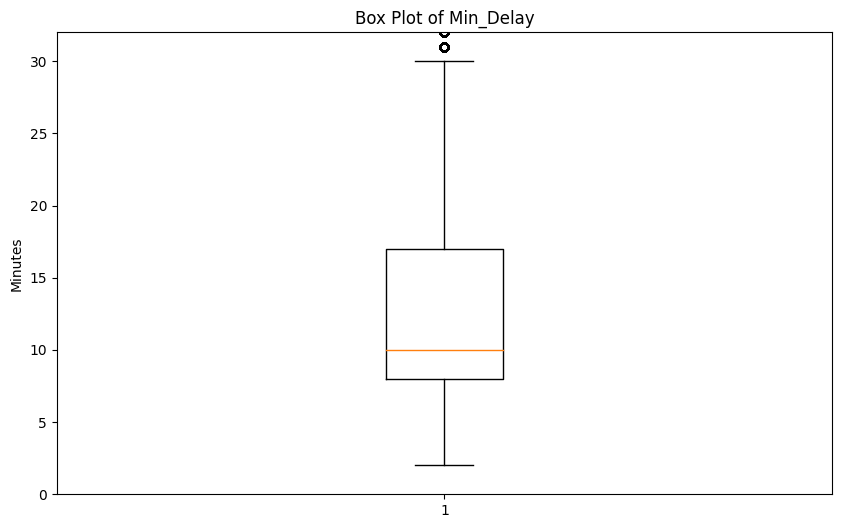

In [23]:
# Set the size of the plot
plt.figure(figsize=(10, 6))

# Draw a box plot of the 'Min_Delay' column
plt.boxplot(ttc_df['Min_Delay'])

# Set custom Y-axis range
plt.ylim(0, ttc_df['Min_Delay'].quantile(0.95))  # Adjust the upper limit as needed

# Set plot title and labels
plt.title('Box Plot of Min_Delay')
plt.ylabel('Minutes')

# Show the plot
plt.show()


In [24]:
# Calculate quartile values
quartiles = ttc_df['Min_Delay'].quantile([0.25, 0.5, 0.75])

# Print quartile values
print("Quartile Values:")
print("25th Percentile (Q1):", quartiles[0.25])
print("Median (Q2):", quartiles[0.5])
print("75th Percentile (Q3):", quartiles[0.75])


Quartile Values:
25th Percentile (Q1): 8.0
Median (Q2): 10.0
75th Percentile (Q3): 17.0


In [25]:
def categorize_delay(delay, q1, q2, q3):
    if delay <= q1:
        return 'Short'
    elif delay <= q2:
        return 'Medium'
    else:
        return 'Long'

# Apply the categorize_delay function to create a new column 'Delay_Category'
ttc_df['Delay_Category'] = ttc_df['Min_Delay'].apply(lambda x: categorize_delay(x, 8.0, 10.0, 17.0))


Min Gap

In [26]:
# Remove rows with values of -2.0 and 0.0 in the 'Min_Gap' column from ttc_df
ttc_df = ttc_df[(ttc_df['Min_Gap'] != -2.0) & (ttc_df['Min_Gap'] != 0.0)]

# Remove Min Gap rows if there's no record of it.
ttc_df = ttc_df[ttc_df['Min_Gap'].notna()]


Direction

In [27]:
# standardizing and simplifying direction strings for easier processing and analysis.
def direction_simplifier(direction):
    direction = str(direction).upper().replace(' ', '')  # Convert to uppercase and remove spaces
    direction = re.sub(r'[^A-Z]', '', direction)  # Remove non-alphabetic characters

    if 'NB' in direction or 'N' in direction or 'NORTH' in direction:
        return 'N'
    elif 'SB' in direction or 'S' in direction or 'SOUTH' in direction:
        return 'S'
    elif 'EB' in direction or 'E' in direction or  'EAST' in direction:
        return 'E'
    elif 'WB' in direction or 'W' in direction or 'WEST' in direction:
        return 'W'
    elif 'BW' in direction or 'BWS' in direction or 'BOTH WAYS' in direction or 'BOTHWAY' in direction or 'BWAYS' in direction or 'B' in direction:
        return 'B'
    else:
        return 'Unknown'


In [28]:
ttc_df['Direction'] =ttc_df['Direction'].apply(direction_simplifier)


In [29]:
ttc_df['Direction'].value_counts()

Direction
N          178634
W          177053
S          123071
E          121432
Unknown      1454
B             155
Name: count, dtype: int64

Incidents

In [30]:
ttc_df.Incident.unique()

array(['Mechanical', 'General Delay', 'Emergency Services',
       'Investigation', 'Late Leaving Garage', 'Diversion',
       'Utilized Off Route', 'Late Leaving Garage - Mechanical',
       'Late Leaving Garage - Management', 'Late Leaving Garage - Vision',
       'Vision', 'Late Leaving Garage - Operator', nan, 'Management',
       'Operations - Operator', 'Cleaning', 'Security', 'Collision - TTC',
       'Road Blocked - NON-TTC Collision',
       'Road Block - Non-TTC Collision',
       'Roadblock by Collision - Non-TTC', 'Securitty',
       'Late Entering Service - Mechanical', 'Cleaning - Unsanitary',
       'Held By', 'Late Entering Service', 'Cleaning - Disinfection',
       'Late Leaving Garage - Operations', 'e', 'Operations',
       'Collision - TTC Involved', 'Late', 'Overhead', 'Rail/Switches'],
      dtype=object)

In [31]:
# Mapping dictionary for categorization
incident_mapping = {
    'Mechanical': 'Mechanical',
    'General Delay': 'Delay',
    'Emergency Services': 'Emergency Services',
    'Investigation': 'Investigation',
    'Diversion': 'Diversion',
    'Late Leaving Garage': 'Delay',
    'Utilized Off Route': 'Utilized Off Route',
    'Late Leaving Garage - Mechanical': 'Mechanical',
    'Late Leaving Garage - Management': 'Management',
    'Late Leaving Garage - Vision': 'Vision',
    'Vision': 'Vision',
    'Late Leaving Garage - Operator': 'Operator',
    'Management': 'Management',
    'Operations - Operator': 'Operations',
    'Cleaning': 'Cleaning',
    'Security': 'Security',
    'Collision - TTC': 'Collision',
    'Road Blocked - NON-TTC Collision': 'Collision',
    'Road Block - Non-TTC Collision': 'Collision',
    'Roadblock by Collision - Non-TTC': 'Collision',
    'Securitty': 'Security',
    'Late Entering Service - Mechanical': 'Mechanical',
    'Cleaning - Unsanitary': 'Cleaning',
    'Held By': 'Management',
    'Late Entering Service': 'Delay',
    'Cleaning - Disinfection': 'Cleaning',
    'Late Leaving Garage - Operations': 'Operations',
    'e': 'Unknown',
    'Operations': 'Operations',
    'Collision - TTC Involved': 'Collision',
    'Late': 'Delay',
    'Overhead': 'Overhead',
    'Rail/Switches': 'Operations'
}


# Update the incident column using the mapping
ttc_df['Incident'] = ttc_df['Incident'].map(incident_mapping)

# Fill NaN values with 'Unknown'
ttc_df['Incident'].fillna('Unknown', inplace=True)

In [32]:
ttc_df.Incident.value_counts()

Incident
Mechanical            222179
Delay                 128992
Utilized Off Route     70812
Investigation          48050
Operations             42078
Diversion              32320
Emergency Services     15400
Cleaning               14900
Collision              11423
Security                9335
Vision                  3220
Operator                1263
Management               938
Unknown                  873
Overhead                  16
Name: count, dtype: int64

Vehicle

In [33]:
# Dropping 'Vehicle' column as it does not provide any valuable insights and most of the data is NaN
ttc_df.drop(columns='Vehicle', axis=1, inplace=True)


# EDA

In [34]:
ttc_df.columns

Index(['Report_Date', 'Route', 'Time', 'Day_of_week', 'Location', 'Incident',
       'Min_Delay', 'Min_Gap', 'Direction', 'Report_Day', 'Report_Month',
       'Report_Year', 'Delay_Category'],
      dtype='object')

In [35]:
# Set the style for seaborn
sns.set_style("whitegrid")

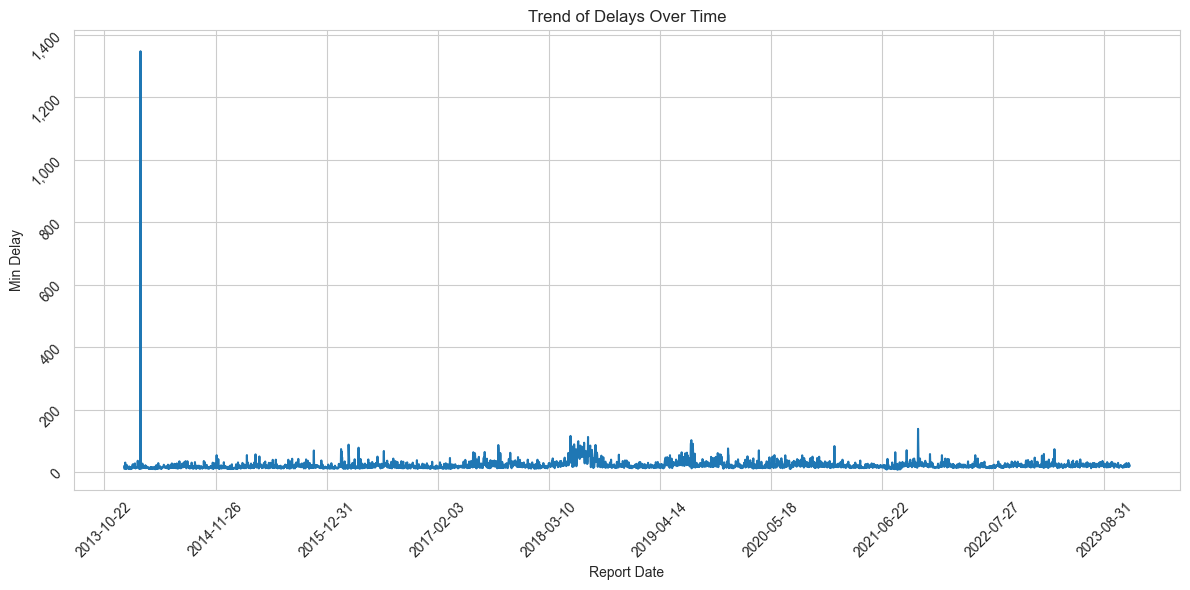

In [36]:
# Plot Trend Analysis: Delays over time
plt.figure(figsize=(12, 6))
sns.lineplot(x='Report_Date', y='Min_Delay', data=ttc_df, ci=None)
plt.title('Trend of Delays Over Time')
plt.xlabel('Report Date')
plt.ylabel('Min Delay')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # Set max number of x-axis ticks
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))  # Format y-axis ticks with commas
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

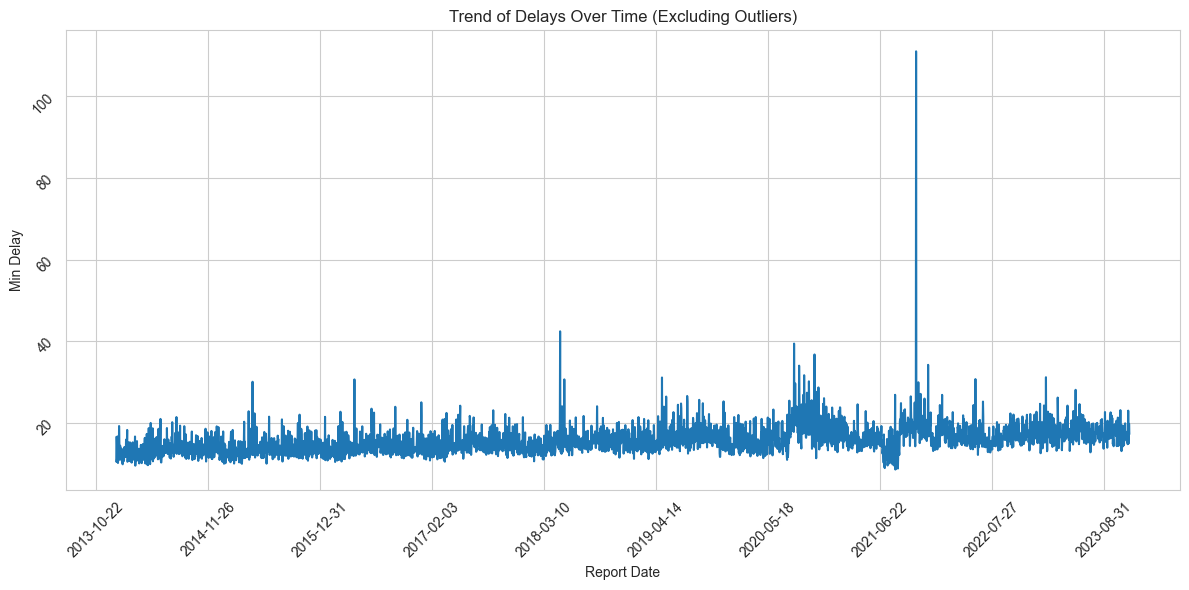

In [37]:
# Filter out delays greater than 200 minutes
filtered_ttc_df = ttc_df[ttc_df['Min_Delay'] <= 200]

# Plot Trend Analysis: Delays over time
plt.figure(figsize=(12, 6))
sns.lineplot(x='Report_Date', y='Min_Delay', data=filtered_ttc_df, ci=None)

plt.title('Trend of Delays Over Time (Excluding Outliers)')
plt.xlabel('Report Date')
plt.ylabel('Min Delay')

plt.xticks(rotation=45)
plt.yticks(rotation=45)

plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # Set max number of x-axis ticks
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))  # Format y-axis ticks with commas
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

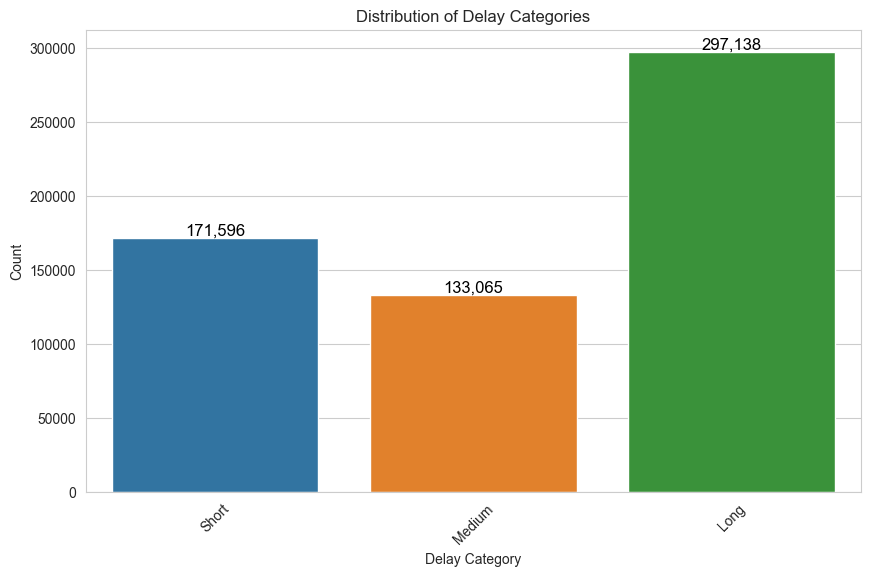

In [38]:
# Define the order of delay categories
delay_category_order = ['Short', 'Medium', 'Long']

# Create the countplot with the specified order
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Delay_Category', data=ttc_df, order=delay_category_order)
plt.title('Distribution of Delay Categories')
plt.xlabel('Delay Category')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Add numbers on top of each bar with commas for readability
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height(), '{:,.0f}'.format(p.get_height()), 
            fontsize=12, color='black', ha='center', va='bottom')

plt.show()


## Which day of the week is the busiest? 

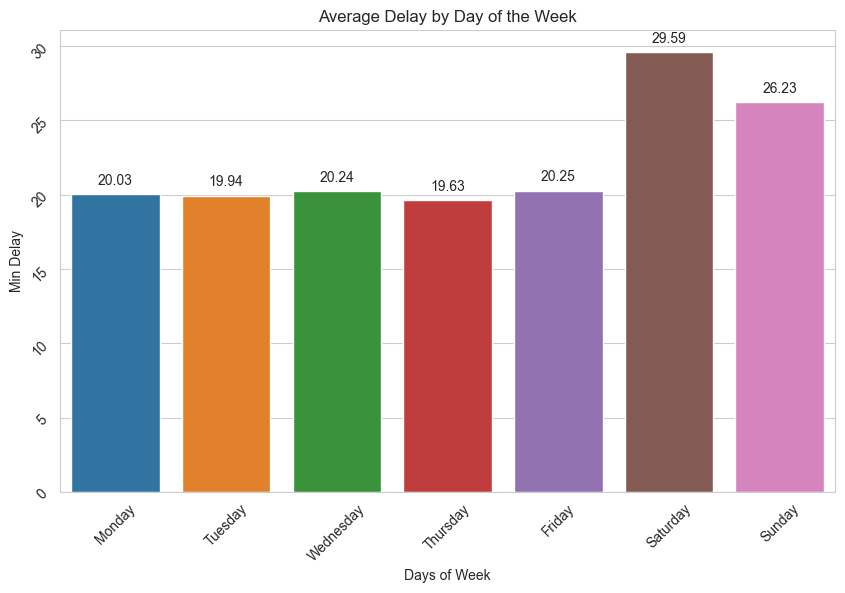

In [39]:
# Average Delay by Day of the Week
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Day_of_week', y='Min_Delay', data=ttc_df, ci=None, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.title("Average Delay by Day of the Week")
plt.xlabel("Days of Week")
plt.ylabel("Min Delay")

plt.xticks(rotation=45)
plt.yticks(rotation=45)

# Add count labels on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()


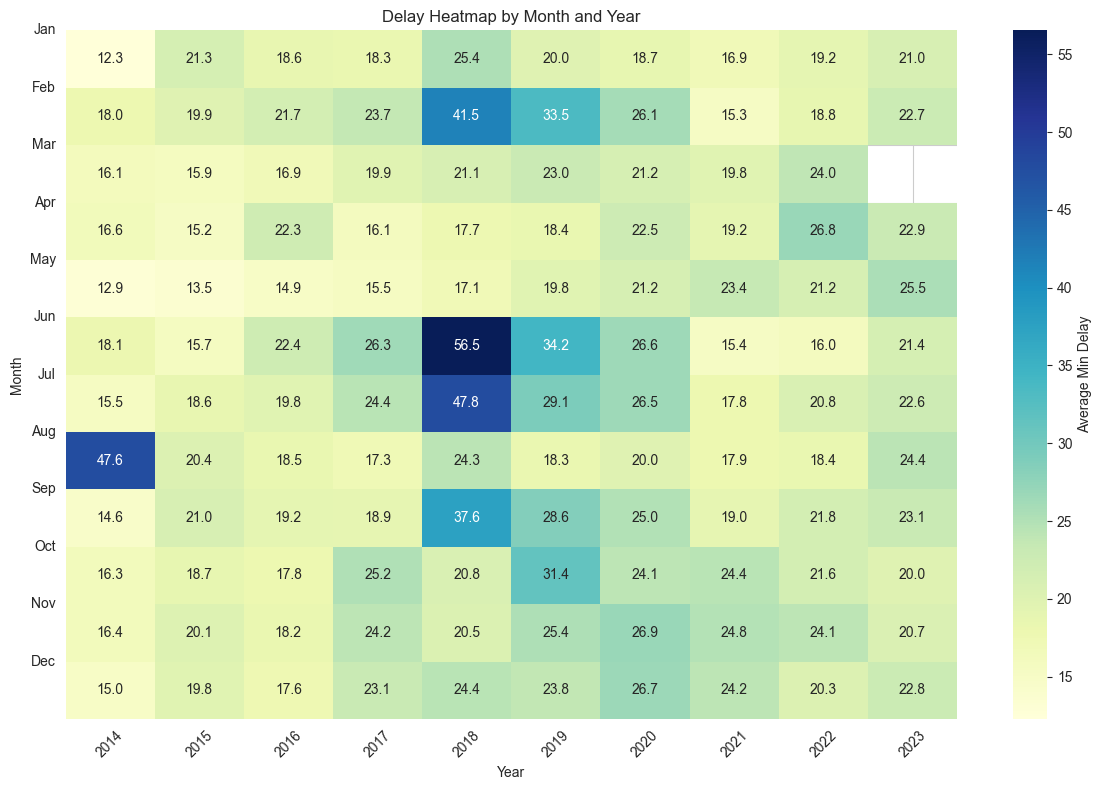

In [40]:
import calendar

# Pivot table
pivot_table = ttc_df.pivot_table(index='Report_Month', columns='Report_Year', values='Min_Delay', aggfunc='mean')

# Create a list of month names
month_names = [calendar.month_abbr[i] for i in range(1, 13)]

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap='YlGnBu', annot=True, fmt=".1f", cbar_kws={'label': 'Average Min Delay'})

# Set title and labels
plt.title('Delay Heatmap by Month and Year')
plt.xlabel('Year')
plt.ylabel('Month')

plt.xticks(rotation=45)
plt.yticks(ticks=range(12), labels=month_names, rotation=0)  # Set custom y-tick labels

# Adjust layout
plt.tight_layout()

plt.show()


## Which is the most common incidents all?

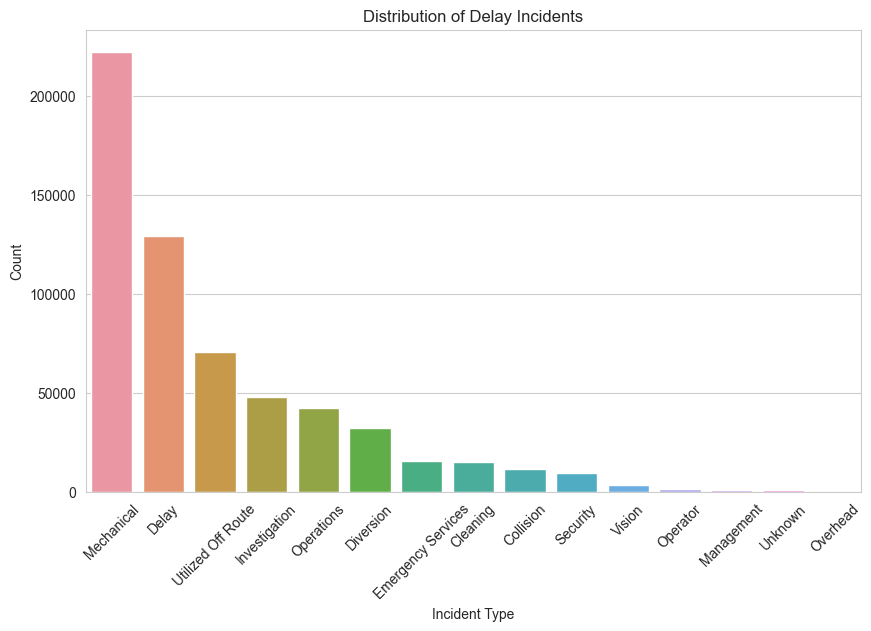

In [41]:
# Most common types of incidents leading to delays
plt.figure(figsize=(10, 6))
sns.countplot(x='Incident', data=ttc_df, order=ttc_df['Incident'].value_counts().index)
plt.title('Distribution of Delay Incidents')
plt.xlabel('Incident Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

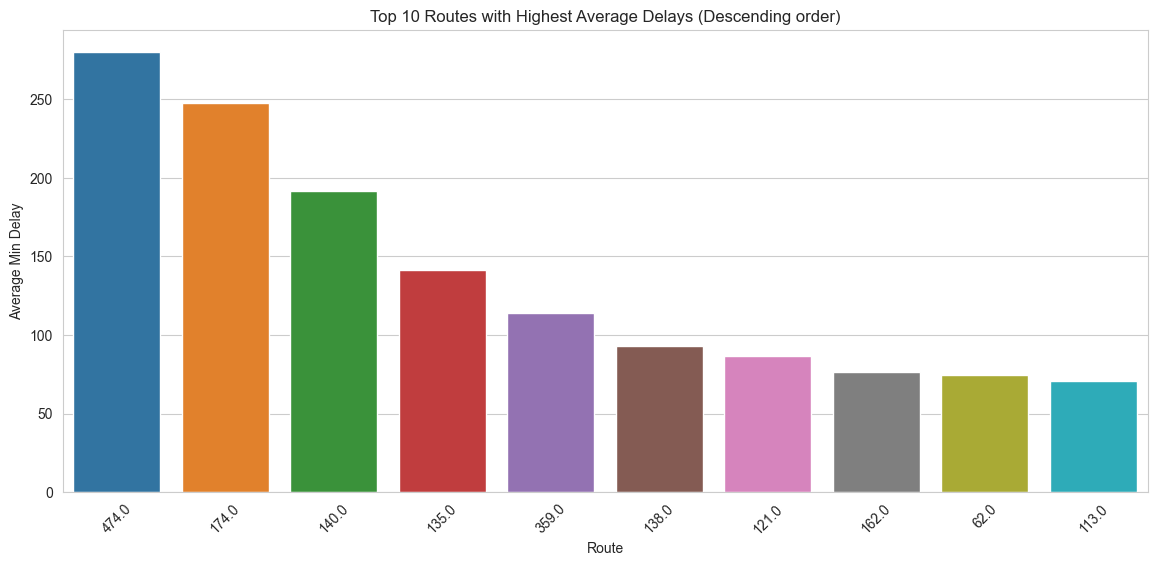

In [42]:
# Calculate the mean delay for each route
route_avg_delay = ttc_df.groupby('Route')['Min_Delay'].mean()

# Sort routes based on average delay in descending order
top_routes_desc = route_avg_delay.sort_values(ascending=False).head(10).index

# Plot the routes with highest average delays
plt.figure(figsize=(14, 6))
sns.barplot(x='Route', y='Min_Delay', data=ttc_df[ttc_df['Route'].isin(top_routes_desc)], ci=None, order=top_routes_desc)
plt.title('Top 10 Routes with Highest Average Delays (Descending order)')
plt.xlabel('Route')
plt.ylabel('Average Min Delay')
plt.xticks(rotation=45)
plt.show()


## Top 10 locations with Most Fewquent Delays

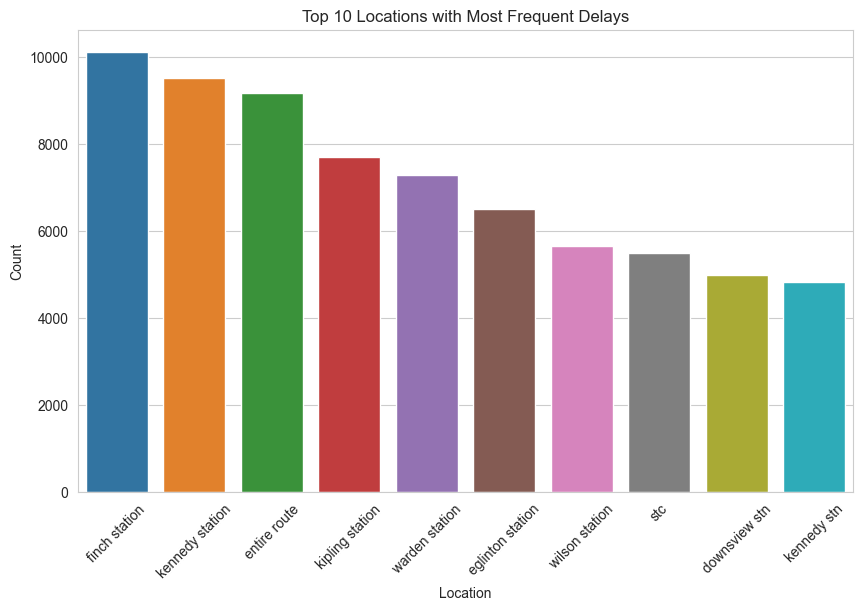

In [43]:
# Locations with most frequent delays
plt.figure(figsize=(10, 6))
sns.countplot(x='Location', data=ttc_df, order=ttc_df['Location'].value_counts().index[:10])
plt.title('Top 10 Locations with Most Frequent Delays')
plt.xlabel('Location')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()